<a href="https://colab.research.google.com/github/Armanskij/EBAC_Studies/blob/main/Projeto/Exercício M16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)<br>
Elaborado por [Douglas Rizzi](https://www.linkedin.com/in/douglas-rizzi/)

---

## **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Explorando os Caminhos da Logística na região de Belém/PA**

![logo](https://raw.githubusercontent.com/Armanskij/EBAC_Studies/main/Projeto/banner_loggi.png)

## 1\. Contexto

   Este  estudo analisa as operações de entrega da **Loggi em Belém**, Pará, utilizando o Loggi Benchmark for Urban Deliveries (**BUD)**. Buscamos otimizar rotas e alocação de recursos, aproveitando dados reais para identificar padrões e soluções para desafios logísticos. Combinando técnicas estatísticas e visualizações de dados, tendo como foco aprimorar a eficiência das entregas e resolver problemas de roteamento.


As instâncias do mundo real fornecidas pela Loggi são cruciais para explorar novas ideias e insights. O objetivo é contribuir para melhorias contínuas nas operações logísticas, não apenas em Belém, mas em toda a área de atuação da empresa.





---



## 2\. Pacotes e bibliotecas

Para iniciar essa análise importaremos os pacotes e bibliotecas que utilizaremos na construção desse projeto. Em resumos suas funções são:



*   **Manipulação de dados**: `json`
*   **Manipulacão da análise**: `pandas`
*   **Visualização**: `matplotlib.pyplot`, `seaborn`
*   **Geocodificação e geolocalização**: `geopandas`, `geopy`, `shapely.geometry`, `Nominatim`


In [1]:
import geopandas as gpd
import geopy
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Polygon, Point




---



## 3\. Exploração de dados

### 3.1 Coleta de dados

Aqui vamos importar os arquivos necessários para trabalhar, eles já passaram pelo processo de extração e pré-tranformação, os deixando aptos para serem utiliza-los nessa projeto, a seguir vou dar uma breve descrição e origem dos arquivos:


*   `deliveries.json`: extraído do repositório da [loggibud](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md), nela encontramos diversos arquivos com dados reais da empresa com problemas que ela enfrenta, a princípio os dados estavam em diversos arquivos `.json`, os quais passaram por um processo de *join* para facilitar o trabalho.
*   `PA_Municipios_2022.shp` e `PA_Municipios_2022.shx`: ambos arquivos trabalham juntos para unir os vetores e georeferenciamento, para gerarem o mapa com seus limites, eles foram extraídos do [site do IBGE](https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas/15759-brasil.html?edicao=16033&t=downloads) onde encontramos as bases cartográficas contínuas de todos os estados do Brasil.



In [3]:
!wget -q "https://github.com/Armanskij/EBAC_Studies/raw/main/Projeto/Analise_exploratoria_dados_logistica_Loggi/deliveries.json" \-O deliveries.json
!wget -q "https://github.com/Armanskij/EBAC_Studies/raw/main/Projeto/Analise_exploratoria_dados_logistica_Loggi/PA_Municipios_2022.shp" -O PA_Municipios_2022.shp
!wget -q "https://github.com/Armanskij/EBAC_Studies/raw/main/Projeto/Analise_exploratoria_dados_logistica_Loggi/PA_Municipios_2022.shx" -O PA_Municipios_2022.shx

In [4]:
#atribuindo data a uma variável
path = '/content/deliveries.json'
with open('/content/deliveries.json', 'r', encoding='utf8') as file:
  data = json.load(file)

### 3.2 Wrangling da Estrutura


In [5]:
deliveries_df = pd.DataFrame(data) #convertendo o dicionário para um df pandas

In [6]:
deliveries_df.head() #visualizando o conteúdo do df

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-0-pa-113,pa-0,"{'lng': -47.93317089927402, 'lat': -1.29233873...",180,"[{'id': '79e85a4655c312270c3a8be473764276', 'p..."
1,cvrp-0-pa-111,pa-0,"{'lng': -47.93317089927402, 'lat': -1.29233873...",180,"[{'id': '7428b84352663236dc9b4acd20481e7', 'po..."
2,cvrp-0-pa-116,pa-0,"{'lng': -47.93317089927402, 'lat': -1.29233873...",180,"[{'id': 'f292ce89cf29a4962c6145beb2294e0e', 'p..."
3,cvrp-0-pa-110,pa-0,"{'lng': -47.93317089927402, 'lat': -1.29233873...",180,"[{'id': 'dab9e6dc28f9b55fd0aeddc954fae3a9', 'p..."
4,cvrp-1-pa-99,pa-1,"{'lng': -48.4419423131219, 'lat': -1.408109487...",180,"[{'id': 'a644b1091d8e4190b0ed0987bff61e91', 'p..."


In [7]:
deliveries_df['deliveries'][0][0] #observando o conteúdo da coluna deliveries

{'id': '79e85a4655c312270c3a8be473764276',
 'point': {'lng': -48.02136280468213, 'lat': -1.4187407280609672},
 'size': 4}

Agora temos uma visão da nossa base de dados bruta, vamos começar a avaliar sua colunas e destacar suas características:


*   `name(str)`: um nome que identifica a entrega, semelhante à uma ID;
*   `region(str)`: hub responsável pela entrega do pedido;
*   `origin(dict)`: coordenadas geográficas do **hub**, onde latitude(lat) e longitude(lng) estão aninhadas;
*   `vehicle_capacity(int)`: registra a capacidade dos veículos usados pelo hub;
*   `deliveries(dict)`: uma estrutura de dicionários numa lista onde encontramos o *id*, *point*(longitude e latitude do endereço de entrega) e *size* (capacidade do veículo de entrega)



Observando que as colunas `origin` e `deliveries` estão com seus dados aninhados, vamos começar a tratar essas colunas para separar seus dados. Inicialmente trabalharemos com a `origin`, nela usaremos o método próprio do pandas chamado [.json_normalize](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html), que basicamente irá 'achatar' os dados semi-estruturados, que serão mesclados (*merge*) ao df original.

In [8]:
#aplicando método normalize
hub_origin_df = pd.json_normalize(deliveries_df['origin'])
hub_origin_df.head()

,lng,lat
0,-47.933171,-1.292339
1,-47.933171,-1.292339
2,-47.933171,-1.292339
3,-47.933171,-1.292339
4,-48.441942,-1.408109


In [9]:
#mesclando o resultado ao df original
deliveries_df = pd.merge(left=deliveries_df,
                         right=hub_origin_df,
                         how='inner',
                         left_index=True,
                         right_index=True)
deliveries_df.head(2)

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-0-pa-113,pa-0,"{'lng': -47.93317089927402, 'lat': -1.29233873...",180,"[{'id': '79e85a4655c312270c3a8be473764276', 'p...",-47.933171,-1.292339
1,cvrp-0-pa-111,pa-0,"{'lng': -47.93317089927402, 'lat': -1.29233873...",180,"[{'id': '7428b84352663236dc9b4acd20481e7', 'po...",-47.933171,-1.292339


In [10]:
#organizando as colunas com as alterações
deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df[['name',
                               'region',
                               'lng',
                               'lat',
                               'vehicle_capacity',
                               'deliveries']]
deliveries_df.head(2)

,name,region,lng,lat,vehicle_capacity,deliveries
0,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,180,"[{'id': '79e85a4655c312270c3a8be473764276', 'p..."
1,cvrp-0-pa-111,pa-0,-47.933171,-1.292339,180,"[{'id': '7428b84352663236dc9b4acd20481e7', 'po..."


Na coluna `deliveries` o método *.json_normalize* não é aplicável pois a estrutura é mais complexa, então usaremos outro método do pandas, o [.explode](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html), que irá transformar cada elemento da lista em um coluna própria.

In [11]:
deliveries_df_exploded_df = deliveries_df[['deliveries']].explode('deliveries')
deliveries_df_exploded_df.head()

,deliveries
0,"{'id': '79e85a4655c312270c3a8be473764276', 'po..."
0,"{'id': 'ff3ef36bb4025b1124c8543df2c3ae', 'poin..."
0,"{'id': 'd3079367c4ca03cc6b9d6f83be733ab1', 'po..."
0,"{'id': '8963a4a05060a69eda3eb58285d540f4', 'po..."
0,"{'id': '54b3d45492f38c09211dc76c51f1f2ad', 'po..."


In [12]:
#com os elementos separados, agora podemos aplicar o normalize e organizar
deliveries_normalizes_df = pd.concat([
    pd.DataFrame(
        deliveries_df_exploded_df['deliveries']
        .apply(lambda record: record['size']))
    .rename(columns={'deliveries':'delivery_size'}),
    pd.DataFrame(
        deliveries_df_exploded_df['deliveries']
        .apply(lambda record: record['point']['lng']))
    .rename(columns={'deliveries':'delivery_lng'}),
    pd.DataFrame(
        deliveries_df_exploded_df['deliveries']
        .apply(lambda record: record['point']['lat']))
    .rename(columns={'deliveries':'delivery_lat'})
], axis=1)
deliveries_normalizes_df.head()

,delivery_size,delivery_lng,delivery_lat
0,4,-48.021363,-1.418741
0,4,-48.189304,-1.344439
0,4,-48.159525,-1.322248
0,9,-48.168608,-1.324492
0,3,-48.140372,-1.378591


In [13]:
# mesclando o resultado do explode
deliveries_df = deliveries_df.drop('deliveries', axis=1)
deliveries_df = pd.merge(left=deliveries_df,
                         right=deliveries_normalizes_df,
                         how='right',
                         left_index=True,
                         right_index=True)
deliveries_df.reset_index(inplace=True, drop=True) #reiniciando o indice
deliveries_df.head(2)

,name,region,lng,lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,180,4,-48.021363,-1.418741
1,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,180,4,-48.189304,-1.344439


### 3.3 Exploração de Schema

In [14]:
# quantidade de linhas x colunas
deliveries_df.shape

(135967, 8)

In [15]:
# nome das colunas
deliveries_df.columns

Index(['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'delivery_size',
       'delivery_lng', 'delivery_lat'],
      dtype='object')

In [16]:
deliveries_df.index

RangeIndex(start=0, stop=135967, step=1)

In [17]:
#resumo das características dos dados de cada coluna
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135967 entries, 0 to 135966
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              135967 non-null  object 
 1   region            135967 non-null  object 
 2   lng               135967 non-null  float64
 3   lat               135967 non-null  float64
 4   vehicle_capacity  135967 non-null  int64  
 5   delivery_size     135967 non-null  int64  
 6   delivery_lng      135967 non-null  float64
 7   delivery_lat      135967 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 8.3+ MB


In [18]:
deliveries_df.dtypes

name                 object
region               object
lng                 float64
lat                 float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

In [19]:
# descrevendo as colunas de 'name' e 'region'
deliveries_df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
name,135967,60,cvrp-1-pa-103,5108
region,135967,2,pa-1,126954


In [20]:
# com essa visualização vemos uma padrão na capacidade dos veículos
deliveries_df.drop(['name', 'region'], axis=1)\
.select_dtypes('int64')\
.describe()\
.transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,135967.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,135967.0,5.482102,2.872858,1.0,3.0,5.0,8.0,10.0


In [21]:
# vemos que em todo nosso df não existem linhas NA,
#evidenciando a qualidade dos dados
deliveries_df.isna().any()

name                False
region              False
lng                 False
lat                 False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool



---



## 4\. Manipulação

### 4.1 Enriquecimento

Agora com os dados já tratados, podemos começar a adicionar novas colunas à fim de facilitar a compreensão dos dados. Como o principal escopo dos dados é a localização, vamos buscar enriquecer esse tipo de dados com a geolocalização. Para converter as latitudes e longitudes em endereços plotados em um mapa iremos usar duas bilbiotecas especializadas nesse tipo de processo, a primeira é o [Nominatim](https://nominatim.org/) que usa processos de geocodificação para converter coordenadas em endereços, e o [Geopy](https://geopy.readthedocs.io/en/stable/) que uso procecessos de geocodificação reversa para obter endereços.

Com essas bibliotecas vamos começar a aplica-lás em nosso dataframe.

In [23]:
# visão geral do o df, trabalharemos com dois grupos: hub's e deliveries
deliveries_df.head()

,name,region,lng,lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,180,4,-48.021363,-1.418741
1,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,180,4,-48.189304,-1.344439
2,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,180,4,-48.159525,-1.322248
3,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,180,9,-48.168608,-1.324492
4,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,180,3,-48.140372,-1.378591


In [24]:
# selecionando  as colunas referente aos hub's
hub_df = deliveries_df[['region', "lng", 'lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)
hub_df.head()

,region,lng,lat
0,pa-0,-47.933171,-1.292339
1,pa-1,-48.441942,-1.408109


In [25]:
# vendo o shape retornado pelo Nominatim
geolocator = Nominatim(user_agent='douglas_ebac_geocoder')

location = geolocator.reverse('-1.2923387357484621, -47.93317089927402')
print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 44477184,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 244551437,
  "lat": "-1.292562799402845",
  "lon": "-47.93316025146275",
  "class": "highway",
  "type": "residential",
  "place_rank": 26,
  "importance": 0.10000999999999993,
  "addresstype": "road",
  "name": "Rua Quinze de Agosto",
  "display_name": "Rua Quinze de Agosto, Nova Olinda, Castanhal, Região Geográfica Imediata de Castanhal, Região Geográfica Intermediária de Castanhal, Pará, Região Norte, 68740-005, Brasil",
  "address": {
    "road": "Rua Quinze de Agosto",
    "neighbourhood": "Nova Olinda",
    "city_district": "Castanhal",
    "city": "Castanhal",
    "municipality": "Região Geográfica Imediata de Castanhal",
    "state_district": "Região Geográfica Intermediária de Castanhal",
    "state": "Pará",
    "ISO3166-2-lvl4": "BR-PA",
    "region": "Região Norte",
    "postcode": "68740-005",
    "country": "Brasil",
    "country

In [26]:
# limitando o número de consultas à 1 por segundo, devido à política de uso
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [27]:
# buscando o endereço dos nossos dois hub's
hub_df['coordinates'] = hub_df['lat']\
.astype(str) + ',' + hub_df['lng'].astype(str)
hub_df['geodata'] = hub_df['coordinates'].apply(geocoder)
hub_df.head()

,region,lng,lat,coordinates,geodata
0,pa-0,-47.933171,-1.292339,"-1.2923387357484621,-47.93317089927402","(Rua Quinze de Agosto, Nova Olinda, Castanhal,..."
1,pa-1,-48.441942,-1.408109,"-1.4081094873729791,-48.4419423131219","(GSEMP-CTO, Avenida Pedro Álvares Cabral, Conj..."


In [28]:
# usando normalize para separar as colunas de lat/lng
hub_geodata_df = pd.json_normalize(
    hub_df['geodata'].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state_district,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.amenity,address.residential,address.suburb
0,44477184,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,244551437,-1.292562799402845,-47.93316025146275,highway,residential,26,0.10001,...,Região Geográfica Intermediária de Castanhal,Pará,BR-PA,Região Norte,68740-005,Brasil,br,NaN,NaN,NaN
1,44099933,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,4531757691,-1.4076245,-48.441877,amenity,post_office,30,0.00001,...,Região Geográfica Intermediária de Belém,Pará,BR-PA,Região Norte,66645-235,Brasil,br,GSEMP-CTO,Conjunto Costa e Silva,Castanheira


In [29]:
hub_geodata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   place_id                2 non-null      int64  
 1   licence                 2 non-null      object 
 2   osm_type                2 non-null      object 
 3   osm_id                  2 non-null      int64  
 4   lat                     2 non-null      object 
 5   lon                     2 non-null      object 
 6   class                   2 non-null      object 
 7   type                    2 non-null      object 
 8   place_rank              2 non-null      int64  
 9   importance              2 non-null      float64
 10  addresstype             2 non-null      object 
 11  name                    2 non-null      object 
 12  display_name            2 non-null      object 
 13  boundingbox             2 non-null      object 
 14  address.road            2 non-null      object

In [30]:
# buscando o distrito e cidade dos hub's e renomeando as colunas
hub_geodata_df = hub_geodata_df[['address.neighbourhood',
                                 'address.city_district',
                                 'address.city']]
hub_geodata_df.rename(columns={'address.neighbourhood':'hub_neighbourhood',
                               'address.city_district':'hub_district',
                               'address.city': 'hub_city'},
                       inplace=True)

hub_geodata_df = hub_geodata_df.drop('hub_neighbourhood', axis=1)
hub_geodata_df.head()


,hub_district,hub_city
0,Castanhal,Castanhal
1,Entroncamento,Belém


In [31]:
# mesclando as dados dos hub's ao df original
hub_df = pd.merge(left=hub_df,
                  right=hub_geodata_df,
                  left_index=True,
                  right_index=True)
hub_df = hub_df[['region',
                 'hub_district',
                 'hub_city']]
hub_df.head()

,region,hub_district,hub_city
0,pa-0,Castanhal,Castanhal
1,pa-1,Entroncamento,Belém


In [32]:
deliveries_df = pd.merge(
    left=deliveries_df,
    right=hub_df,
    how='inner',
    on='region')
deliveries_df = deliveries_df[['name',
                               'region',
                               'lng',
                               'lat',
                               'hub_city',
                               'hub_district',
                               'vehicle_capacity',
                               'delivery_size',
                               'delivery_lng',
                               'delivery_lat'
                               ]]
deliveries_df.head(2)

,name,region,lng,lat,hub_city,hub_district,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,Castanhal,Castanhal,180,4,-48.021363,-1.418741
1,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,Castanhal,Castanhal,180,4,-48.189304,-1.344439


### 4.2 Controle de Qualidade

In [33]:
# revendo a consistência dos dados
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135967 entries, 0 to 135966
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              135967 non-null  object 
 1   region            135967 non-null  object 
 2   lng               135967 non-null  float64
 3   lat               135967 non-null  float64
 4   hub_city          135967 non-null  object 
 5   hub_district      135967 non-null  object 
 6   vehicle_capacity  135967 non-null  int64  
 7   delivery_size     135967 non-null  int64  
 8   delivery_lng      135967 non-null  float64
 9   delivery_lat      135967 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 11.4+ MB


In [34]:
deliveries_df.isna().any()

name                False
region              False
lng                 False
lat                 False
hub_city            False
hub_district        False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

In [35]:
prop_df = deliveries_df[['region']].isna().sum()/len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

region    0.0
dtype: float64



---



## 5\. Visualização

### 5.1 Mapas


In [37]:
# copiando os arquivos de mapa
!cp ./content/PA_Municipios_2022.shp
!cp ./content/PA_Municipios_2022.shx

cp: missing destination file operand after './content/PA_Municipios_2022.shp'
Try 'cp --help' for more information.
cp: missing destination file operand after './content/PA_Municipios_2022.shx'
Try 'cp --help' for more information.


In [38]:
# visualizando o arquivo
mapa = gpd.read_file('/content/PA_Municipios_2022.shp')
mapa = mapa
mapa.head()

,geometry
0,"POLYGON ((-48.91969 -1.94722, -48.91996 -1.946..."
1,"POLYGON ((-48.39828 -4.86941, -48.39526 -4.870..."
2,"POLYGON ((-48.36255 -1.47566, -48.36046 -1.473..."
3,"POLYGON ((-50.58316 -0.66965, -50.58467 -0.669..."
4,"POLYGON ((-50.53100 -7.14231, -50.53114 -7.142..."


<Axes: >

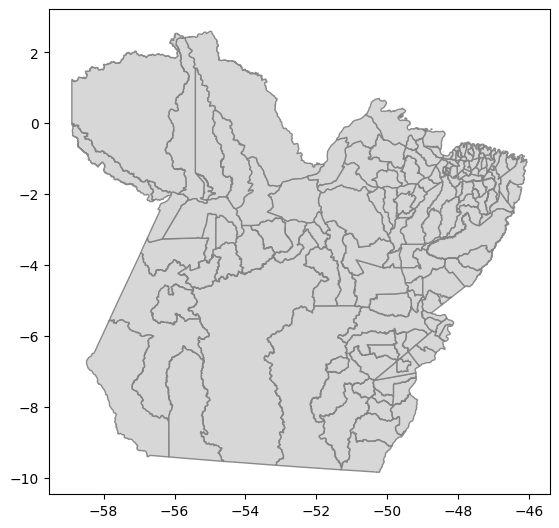

In [39]:
# plotando os poligonos que formam o mapa do estado
fig, ax = plt.subplots(figsize=(20/2.54,16/2.54))
mapa.plot(ax=ax, alpha=0.9, color='lightgrey', edgecolor='grey')

In [40]:
# encontrando as coordenadas dos hub's
hub_df = deliveries_df[['region', 'lng', 'lat']]\
.drop_duplicates()\
.reset_index(drop=True)
geo_hub_df = gpd.GeoDataFrame(
    hub_df,
    geometry=gpd.points_from_xy(
        hub_df['lng'],
        hub_df['lat']))
geo_hub_df.head()

,region,lng,lat,geometry
0,pa-0,-47.933171,-1.292339,POINT (-47.93317 -1.29234)
1,pa-1,-48.441942,-1.408109,POINT (-48.44194 -1.40811)


In [41]:
#encontrando as coordenadas das deliveries
geo_deliveries_df = gpd.GeoDataFrame(
    deliveries_df,
    geometry=gpd.points_from_xy(
        deliveries_df['delivery_lng'],
        deliveries_df['delivery_lat']))
geo_deliveries_df.head(3)

,name,region,lng,lat,hub_city,hub_district,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,geometry
0,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,Castanhal,Castanhal,180,4,-48.021363,-1.418741,POINT (-48.02136 -1.41874)
1,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,Castanhal,Castanhal,180,4,-48.189304,-1.344439,POINT (-48.18930 -1.34444)
2,cvrp-0-pa-113,pa-0,-47.933171,-1.292339,Castanhal,Castanhal,180,4,-48.159525,-1.322248,POINT (-48.15953 -1.32225)


<ipython-input-42-6db8a7fcc902>:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


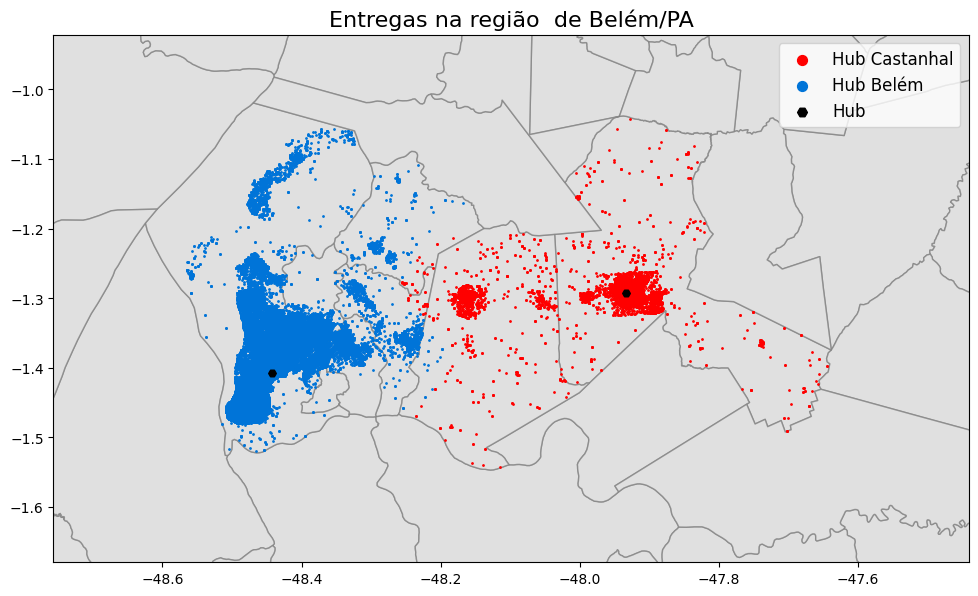

In [42]:
fig, ax = plt.subplots(figsize = (30/2.54, 30/2.54))

mapa.plot(ax=ax, alpha=0.7, color='lightgrey', edgecolor='grey')

geo_deliveries_df.query("region == 'pa-0'").plot(
    ax=ax,
    markersize=1,
    color='#FF0000',
    label='Hub Castanhal')
geo_deliveries_df.query("region == 'pa-1'").plot(
    ax=ax,
    markersize=1,
    color='#0074D8',
    label='Hub Belém')

geo_hub_df.plot(ax=ax, markersize=30, marker='H', color='black', label='Hub')

plt.title('Entregas na região  de Belém/PA', fontsize=16)
lgnd = plt.legend(prop={'size':12})

#coordenadas para aproximar o mapa da região
minx, miny = -48.75665961650764, -1.679871811998348
maxx, maxy = -47.44064516910352, -0.9216371749278345

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

for handle in lgnd.legendHandles:
  handle.set_sizes([50])

In [43]:
# criando um objeto polygon com as min e max de aproximação
bbox = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)])
mapa = gpd.read_file('/content/PA_Municipios_2022.shp')

# selecionando partes do mapa que estão dentro da caixa delimitadora
selected_mapa = mapa[mapa.geometry.within(bbox)]

# exibindo as partes selecionadas do mapa
print(selected_mapa)

                                              geometry
9    POLYGON ((-48.39812 -1.39276, -48.39812 -1.393...
18   POLYGON ((-48.52311 -1.38200, -48.52579 -1.377...
20   POLYGON ((-48.28103 -1.38272, -48.28103 -1.382...
35   POLYGON ((-47.87884 -1.32031, -47.91362 -1.353...
54   POLYGON ((-47.98753 -1.50790, -47.98729 -1.506...
68   POLYGON ((-48.36375 -1.40138, -48.36376 -1.401...
106  POLYGON ((-48.25093 -1.28638, -48.25104 -1.286...
108  POLYGON ((-48.19768 -1.50090, -48.19805 -1.500...
115  POLYGON ((-48.12621 -1.19883, -48.12682 -1.199...
120  POLYGON ((-47.77898 -1.30517, -47.80217 -1.303...
131  POLYGON ((-47.82407 -1.06341, -47.82415 -1.063...


In [44]:
# nomeando cara poligono de acordo seu respectivo município
mapa_ananindeua = mapa.loc[[9]]
mapa_belem = mapa.loc[[18]]
mapa_benevides = mapa.loc[[20]]
mapa_castanhal = mapa.loc[[35]]
mapa_inhangapi = mapa.loc[[54]]
mapa_marituba = mapa.loc[[68]]
mapa_santabarbara = mapa.loc[[106]]
mapa_santaisabel = mapa.loc[[108]]
mapa_santoantonio = mapa.loc[[115]]
mapa_saofrancisco = mapa.loc[[120]]
mapa_terraalta = mapa.loc[[131]]

<ipython-input-45-706fb8684ddc>:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


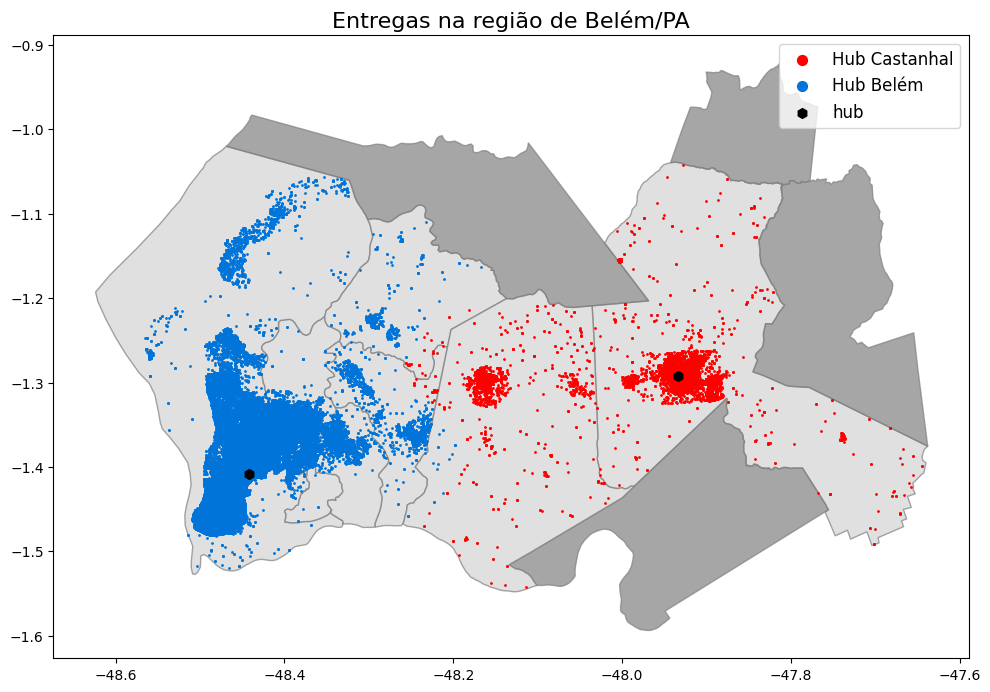

In [45]:
#refazendo o mapa focando nos municípios de interesse
fig, ax = plt.subplots(figsize = (30/2.54, 30/2.54))

mapa_ananindeua.plot(ax=ax, alpha=0.7, color='lightgrey', edgecolor='gray')
mapa_belem.plot(ax=ax, alpha=0.7, color='lightgrey', edgecolor='gray')
mapa_benevides.plot(ax=ax, alpha=0.7, color='lightgrey', edgecolor='gray')
mapa_castanhal.plot(ax=ax, alpha=0.7, color='lightgrey', edgecolor='gray')
mapa_inhangapi.plot(ax=ax, alpha=0.7, color='gray', edgecolor='gray')
mapa_marituba.plot(ax=ax, alpha=0.7, color='lightgrey', edgecolor='gray')
mapa_santabarbara.plot(ax=ax, alpha=0.7, color='lightgrey', edgecolor='gray')
mapa_santaisabel.plot(ax=ax, alpha=0.7, color='lightgrey', edgecolor='gray')
mapa_santoantonio.plot(ax=ax, alpha=0.7, color='gray', edgecolor='gray')
mapa_saofrancisco.plot(ax=ax, alpha=0.7, color='gray', edgecolor='gray')
mapa_terraalta.plot(ax=ax, alpha=0.7, color='gray', edgecolor='gray')

geo_deliveries_df.query("region == 'pa-0'").plot(
    ax=ax,
    markersize=1,
    color='#FF0000',
    label='Hub Castanhal')
geo_deliveries_df.query("region == 'pa-1'").plot(
    ax=ax,
    markersize=1,
    color='#0074D8',
    label='Hub Belém')

geo_hub_df.plot(ax=ax, markersize=50, marker='h', color='black', label='hub')

plt.title('Entregas na região de Belém/PA', fontsize=16)
lgnd = plt.legend(prop={'size':12})


for handle in lgnd.legendHandles:
  handle.set_sizes([50])

**Insight**: Por ser uma capital média em comparação as outras (1,3 milhão em 2022), existem apenas dois hub's de entrega em toda região metropolitana de Belém. Localizadas nos municípios de Belém e Castanhal eles atendem cerca outros 5 municípios.

Por atender a capital o hub de Belém aparenta ter maior número de entregas em mais múnicipios, já o hub de Castanhal tem um menor número de entregas e de distribuidas mais espaçadamente. Ambos os hub's tem suas áreas de entregas bem delimitadas, havendo uma boa distribuição geográfica entre elas.

Observamos que nessa região os centros dos municípios acumulam grande parte das entregas (inclusive no hub de Castanhal podemos ver dois grandes grupos que representam isso) as demais entregas são bem espaçadas. Uma sugestão de melhoria para a cobertura da empresa seria estudar o municípios vizinhos(destacos em cinza) para observar a demanda pela serviço nelas, e assim fazer com que os hub's existem comecem a atender eles, ou até mesmo que se crie um novo hub.

### 5.2 Tabelas para gráfico


In [46]:
#criando um df para ver a proporção de entregas
data = pd.DataFrame(
    deliveries_df[['region', 'vehicle_capacity']].sort_values(by='region'))
data = data.value_counts(normalize=True).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data

,region,vehicle_capacity,region_percent
0,pa-1,180,0.933712
1,pa-0,180,0.066288


<ipython-input-47-96d654990c2c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot\


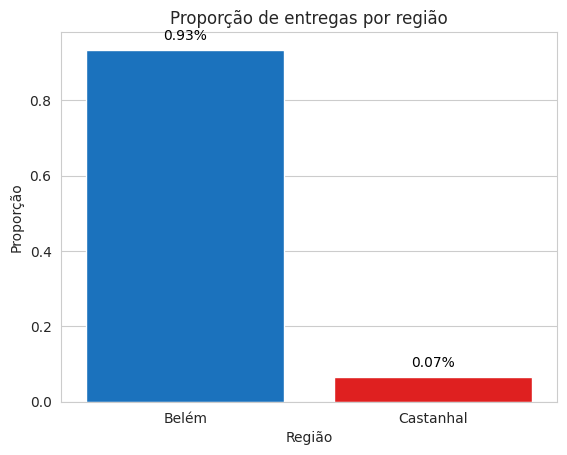

In [47]:
data['region'] = data['region'].replace({'pa-0': 'Castanhal', 'pa-1': 'Belém'})
with sns.axes_style('whitegrid'):
  colors = ['#0074D8','#FF0000']
  grafico = sns.barplot\
   (data=data,
    x="region",
    y="region_percent",
    errorbar=None,
    palette=colors)
  grafico.set(
      title='Proporção de entregas por região',
      xlabel='Região',
      ylabel='Proporção');
for index, row in data.iterrows():
        grafico.annotate(f"{row['region_percent']:.2f}%",
                         xy=(row.name, row['region_percent']),
                         xytext=(0, 5),
                         textcoords="offset points",
                         ha='center', va='bottom')

**Insight**: A diferença do número de entregas é bem grande, monstrando que por mais que os dois hub's atendam quase a mesma área, a condensação das entregas na capital Belém superam muito as entregas difusas de Castanhal. Diante disso podemos avaliar que o investimento no hub de Belém irá retornar um ótimo resultado, uma vez que nele se concentra quase todo o trabalho da empresa na região.

In [77]:
delivery_bycity = gpd.sjoin(geo_deliveries_df, mapa, predicate='within')

In [78]:
print(
    f"{geo_deliveries_df.columns.to_list()}\
    \n{delivery_bycity.columns.to_list()}")

['name', 'region', 'lng', 'lat', 'hub_city', 'hub_district', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat', 'geometry']    
['name', 'region', 'lng', 'lat', 'hub_city', 'hub_district', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat', 'geometry', 'index_right']


In [75]:
#atribuindo nome a cada código
index_city ={
    9: 'Ananideua',
    18: 'Belém',
    20: 'Benevides',
    35: 'Castanhal',
    54: 'Inhanngapi',
    68: 'Marituba',
    106: 'Santa Bárbara do Pará',
    108: 'Santa Isabel do Pará',
    115: 'Santo Antônio do Tauá',
    120: 'São Francisco do Pará',
    131: 'Terra Alta'
}

In [79]:
# filtrando as colunas de interesse e mapeando os municípios
delivery_bycity['delivery_city'] = delivery_bycity['index_right']\
.map(index_city)
delivery_bycity = delivery_bycity[['region', 'delivery_city', 'delivery_size']]
delivery_bycity = delivery_bycity\
.groupby(['region', 'delivery_city'])\
.size()\
.reset_index(name='count')

In [80]:
delivery_bycity = delivery_bycity[delivery_bycity['count']>20]
delivery_bycity = delivery_bycity.sort_values(by='region', ascending=True)

In [53]:
delivery_bycity

,region,delivery_city,count
0,pa-0,Benevides,39
1,pa-0,Castanhal,7101
2,pa-0,Santa Bárbara do Pará,30
3,pa-0,Santa Isabel do Pará,1843
4,pa-1,Ananideua,23140
5,pa-1,Belém,98042
6,pa-1,Benevides,1763
7,pa-1,Marituba,3545
8,pa-1,Santa Bárbara do Pará,445


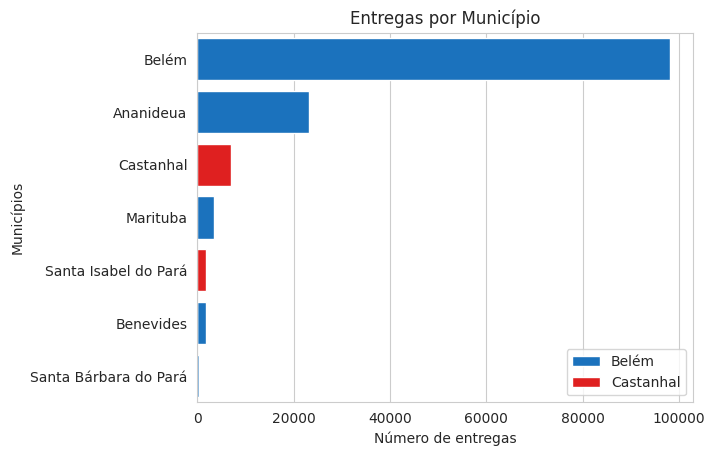

In [95]:
# trocando nome para legenda
delivery_bycity['region'] = delivery_bycity['region'].replace(
    {'pa-0': 'Castanhal',
     'pa-1': 'Belém'})
# ordenando do maior para o menor
delivery_bycity_sorted = delivery_bycity.sort_values(
    by='count',
    ascending=False)
# escolhendo as cores
cores = {'Castanhal':'#FF0000', 'Belém':'#0074D8'}

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(
      data=delivery_bycity_sorted,
      x='count',
      y='delivery_city',
      hue='region',
      dodge=False,
      errorbar=None,
      palette=cores)
  grafico.set(
      title='Entregas por Município',
      xlabel='Número de entregas',
      ylabel='Municípios')
  plt.legend(loc='lower right')

**Insigt**: Quando observamos os municípios com mais entregas vemos que eles seguem o padrão de entregas por região, destacando que em Castanhal temos a maior quantidade do hub de Castanhal, onde provavelmente teremos um bom potêncial de crescimento.

## 6\. Conclusão

Observando os dataframes, mapas e gráficos podemos observar três linhas de raciocínio principais:



1.   **Estrutura Logística e Distribuição Geográfica**: Os dois Hub's vêm atendendo bem à região, suas entregas estão bem ordenadas e seus limites estão bem estabelecidos, e de modo geral elas se concentram nos centros urbanos, havendo poucas entregas para o interior. Isso mostra que as rotas estão estruturadas para atender satisfatoriamente e dentro do prazo, com base nelas pode-se tirar uma boa **base** para expandir para outros municípios.


2.   **Investimento estratégico na Hub de Belém**: Tendo em mente que a maioria das entregas é feita pela Hub de Belém, podemos considerar que é nele que as decisões mais estratégicas devem ser tomadas, pois é nele onde temos um retorno mais garantido. Melhorias de **tecnologias** e **atendimento** ao cliente terão bem mais retorno nesse Hub.


3.   **Padrão de entregas e potencial crescimento em Castanhal**: Dentre as entregas feitas pelo Hub de Castanhal a maioria se concentra no centro do próprio município, e as demais entregas são bem mais espaçadas, criando assim dois grupos de rotas. Diante disso, vemos o potencial de expandir a operação para municípios vizinhos, logo investimentos em **infraestrutura** e **novos clientes** serão muito bem aproveitados pelo Hub.





![Pará](https://live.staticflickr.com/7089/7246428670_cf58925d42_k.jpg)
*Vista panorâmica da cidade de Belém (Riker, Arnoldo - 2012)*